# Performance Evaluation

## Helper Functions

In [1]:
### install necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [2]:
### defining labels
class_labels = ["unverifiable", "false", "mostly false", "half true", "mostly true", "true"]
class_2_index = {label: i for i, label in enumerate(class_labels)}
index_2_class = {i: label for i, label in enumerate(class_labels)}
num_labels = [class_2_index[label] for label in class_labels] # [0, 1, 2, 3, 4, 5]

In [3]:
### functions to generate confusion matrix and metrics
def generate_cm(y_true, y_pred):
    '''
    Calculate the confusion matrix with the cost matrix
    '''
    cm = confusion_matrix(y_true, y_pred)
    return cm

def generate_metrics(y_true, y_pred):
    '''
    Calculate the weighted F1 score
    '''
    weighted_precision = precision_score(y_true, y_pred, average='weighted', sample_weight=None, labels=num_labels)
    weighted_recall = recall_score(y_true, y_pred, average='weighted', sample_weight=None, labels=num_labels)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted', sample_weight=None, labels=num_labels)
    metrics = pd.DataFrame({'Precision': weighted_precision, 'Recall': weighted_recall, 'F1': weighted_f1}, index=class_labels)
    return metrics

## Label Generation

In [4]:
### load the data
df = pd.read_csv('../data/pilot_updated_v3.csv')
statements = df['statement'].to_list()
statement_dates = df['statement_date'].to_list()
statement_originators = df['statement_originator'].to_list()
gold = df['verdict'].to_list()

'''
Creates a list of strings that contain the statement, source, and date in the following format:
Statement: {statement}
According to: {source}
Date: {date}
'''
statements_agg = [f"""Statement: {statement} \n According to: {source} \n Date: {date}""" for statement, source, date in zip(statements, statement_originators, statement_dates)]

In [5]:
### generate results
def generate_results(statements: list, 
                     old_file: str = None, 
                     new_file: str = None):
    '''
    generate and store results for a list of statements
    make sure to:
    (1) load the old results if they exist
    (2) initialize the pipeline and define LM before running
    (3) run %%capture to suppress output

    '''
    # load results if it exists
    results = []
    if os.path.exists(old_file):
        with open(old_file, 'rb') as f:
            
            results = pickle.load(f)

    for index, statement in enumerate(tqdm(statements)):
        if len(results) <= index+1 and type(results[index]) != int:
            continue
        verdict = None

        # retry 5 times if there is an error
        for i in range(5):
            try:
                verdict, confidence, reasoning, claims = pipeline.fact_check(statement)
            except Exception as e:
                print(f"Error {e}: retrying for statement {index}, attempt {i+1}")
                continue 
            break   
        
        if verdict is None:
            results.append(index)
        else:
            results.append((verdict, confidence, reasoning, claims))
        with open(new_file, 'wb') as f:
            pickle.dump(results, f)

In [7]:
### generate results dataframe
def generate_results_df(results_filename: str,
                        df_filename: str):
    '''
    convert results to a dataframe and save it
    '''
    if os.path.exists(results_filename):
        with open(results_filename, 'rb') as f:
            results = pickle.load(f)
    results_df = pd.DataFrame(data=results, columns=['verdict', 'confidence', 'reasoning', 'claims'])
    results_df.to_csv(df_filename)
    return results_df

### Gemini

In [6]:
%reload_ext autoreload
%autoreload 2

### load fact-checking pipeline
import dotenv
import sys
import dspy
import os
sys.path.append('../pipeline_v2/')
import main
dotenv.load_dotenv('../.env')

# initialize search provider
main.NUM_SEARCH_RESULTS = 10 # Number of search results to retrieve
main.SCRAPE_TIMEOUT = 5 # Timeout for scraping a webpage (in seconds)
search_provider = main.SearchProvider(provider="duckduckgo")

# initialize DSPy
lm = dspy.LM('gemini/gemini-1.5-flash', api_key=os.getenv('GOOGLE_GEMINI_API_KEY'), cache=False)
#lm = dspy.LM('ollama_chat/mistral', api_base='http://localhost:11434', api_key='')
dspy.settings.configure(lm=lm)

# initialize pipeline
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
main.VERBOSE = True # Print intermediate results
main.INTERACTIVE = False # Allow the user to provide feedback
main.USE_BM25 = True # Use BM25 for retrieval (in addition to cosine similarity)
main.BM25_WEIGHT = 0.5 # Weight for BM25 in the hybrid retrieval

pipeline = main.FactCheckPipeline(
    search_provider=search_provider,
    model_name=lm,
    embedding_model=embedding_model,
    retriever_k=2
)

/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


In [48]:
statement = statements_agg[0]
verdict, confidence, reasoning, claims = pipeline.fact_check(statement, web_search=True)

===== Starting Fact Check Pipeline =====
 Original Statement: Statement: "House Republicans took numerous votes that would have damaged economic growth and harmed our national security, like attempting to eliminate over 2,000 Border Patrol agents." 
 According to: Deputy White House press secretary Andrew Bates 
 Date: 2024-01-10 
  ===== Atomic Claim Extraction =====
   Extracted Claims (1):  
     1. According to Deputy White House press secretary Andrew Bates on 2024-01-10, House Republicans took numerous votes that would have damaged economic growth and harmed our national security, including an attempt to eliminate over 2,000 Border Patrol agents. 
    ===== Question Generation [1/1] =====
       Decomposed Components (Questions + Search Queries) (3): 
         1. Question: What specific votes did House Republicans take that the White House claims would damage economic growth and national security? 
            Search Queries: ['House Republican votes economic impact 2024', 'House

TypeError: object of type 'NoneType' has no len()

### Mistral

In [35]:
%reload_ext autoreload
%autoreload 2
import dotenv
import sys
import dspy
import os
sys.path.append('../pipeline_v2/')
import main 
dotenv.load_dotenv('../.env')

# Initialize search provider
main.NUM_SEARCH_RESULTS = 10 # Number of search results to retrieve
main.SCRAPE_TIMEOUT = 5 # Timeout for scraping a webpage (in seconds)
search_provider = main.SearchProvider(provider="duckduckgo")

# Initialize DSPy
lm = dspy.LM('ollama_chat/mistral-custom', api_base='http://localhost:11434', api_key='')
dspy.settings.configure(lm=lm)

# Initialize pipeline
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
main.VERBOSE = False # Print intermediate results
main.INTERACTIVE = False # Allow the user to provide feedback
main.USE_BM25 = True # Use BM25 for retrieval (in addition to cosine similarity)
main.BM25_WEIGHT = 0.5 # Weight for BM25 in the hybrid retrieval

pipeline = main.FactCheckPipeline(
    search_provider=search_provider,
    model_name=lm,
    embedding_model=embedding_model,
    retriever_k=2
)


# PolitiFact Scraper

In [ ]:
import requests
import re
from bs4 import BeautifulSoup
import dateutil.parser as dparser
def scrape_politifact(url):
    """Scrapes text and metadata from a given website URL."""
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            article_element = soup.find('article', class_='m-textblock')
            statement = soup.find('div', class_='m-statement__quote').get_text()
            statement = re.sub(r'\s+', ' ', statement).strip()

            verdict = soup.find('div', class_='m-statement__meter').find('img').get('alt').upper().replace('-',' ')
            if verdict == 'BARELY TRUE':
                verdict = 'MOSTLY FALSE'
            author = soup.find('div',class_="m-statement__author")
            statement_originator = author.find('a',class_='m-statement__name').get_text()
            statement_originator = re.sub(r'\s+', ' ', statement_originator).strip()
            
            statement_date = author.find('div',class_='m-statement__desc').get_text()
            statement_date = re.sub(r'\s+', ' ', statement_date).strip()
            statement_date = dparser.parse(statement_date,fuzzy=True).strftime('%m/%d/%Y')
            if article_element:
                section_element = article_element.find('section', class_='o-pick')
                if section_element:
                    section_element.decompose()
                article_text = article_element.get_text()
                article_text = article_text.replace(u'\xa0', u' ')
                reasoning = re.sub(r'\s+', ' ', article_text).strip()
            return verdict, statement_originator, statement, statement_date, reasoning, url
    except Exception as e:
        print(f"Error during website scraping: {e}")
        return None

In [ ]:
factcheck_urls = [
    "https://www.politifact.com/factchecks/list/?ruling=half-true",
    "https://www.politifact.com/factchecks/list/?ruling=true",
    "https://www.politifact.com/factchecks/list/?ruling=false",
    "https://www.politifact.com/factchecks/list/?ruling=mostly-true",
    "https://www.politifact.com/factchecks/list/?ruling=barely-true",
    "https://www.politifact.com/factchecks/list/?ruling=pants-fire",
]

In [22]:
data = []
for ruling in factcheck_urls:
    response = requests.get(ruling, timeout=5)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        article_element = soup.find_all('li', class_='o-listicle__item')
    for i in range(30):
        ref = article_element[i].find('div', class_='m-statement__quote').find('a').get('href')
        url = f'https://www.politifact.com{ref}'
        news = scrape_politifact(url)
        data.append(news)

Error during website scraping: bad month number 27; must be 1-12: dicho el Septiembre 27, 2024 en un anuncio de campaña:
Error during website scraping: hour must be in 0..23: stated on October 7, 2024 in an interview on CBS's "60 Minutes":
Error during website scraping: bad month number 19; must be 1-12: dicho el Septiembre 19, 2024 en una audiencia en la Cámara de Representantes:
Error during website scraping: bad month number 22; must be 1-12: dicho el Agosto 22, 2024 en su discurso de aceptación en la Convención Nacional Demócrata:
Error during website scraping: bad month number 25; must be 1-12: dicho el Febrero 25, 2025 en una publicación en Facebook:
Error during website scraping: bad month number 17; must be 1-12: dicho el Febrero 17, 2025 en una publicación en Facebook:
Error during website scraping: bad month number 17; must be 1-12: dicho el Febrero 17, 2025 en una publicación en Facebook:
Error during website scraping: Unknown string format: stated on January 11, 2025 in a J

# Multiclass classification

In [19]:
import pandas as pd
import sys
sys.path.append('../pipeline_v2/')
import main 
import numpy as np
import pickle
import matplotlib.pyplot as plt 

# import eval data
df_gemini = pd.read_pickle('results_v2_gemini.pkl')
df_mistral = pd.read_pickle('results_v2_mistral.pkl')

### Evaluation metrics (e.g., F1)

In [20]:
# Define the ordinal mapping
VERDICT_MAP = {
    "TRUE": 5,
    "MOSTLY TRUE": 4,
    "HALF TRUE": 3,
    "MOSTLY FALSE": 2,
    "FALSE": 1,
    "UNVERIFIABLE": 0,
    # Weird cases
    "PANTS ON FIRE": 1, # Pants on fire is the same as false
    "MOSTLY UNVERIFIABLE": 0,
    "INDIFFERENT": 0,
    'MOSTLY HALF TRUE': 4,
    'PARTIALLY TRUE': 3,
}

def get_results(df):
    '''Convert verdicts to numeric values'''
    true_verdicts = [VERDICT_MAP[v] for v in df['verdict']]
    pass1_preds_baseline = [VERDICT_MAP[v] for v in df['baseline_pass1_verdict']]
    pass1_preds_pipeline = [VERDICT_MAP[v] for v in df['pipeline_pass1_verdict']]
    pass3_preds_baseline = [VERDICT_MAP[v] for v in df['baseline_pass3_verdict']]
    pass3_preds_pipeline = [VERDICT_MAP[v] for v in df['pipeline_pass3_verdict']]

    cohen_base_1_idx = [i for i, e in enumerate(pass1_preds_baseline) if e == 0]
    cohen_base_1_true = [e for i, e in enumerate(true_verdicts) if i not in cohen_base_1_idx]
    cohen_base_1_pred = [e for i, e in enumerate(pass1_preds_baseline) if i not in cohen_base_1_idx]

    cohen_pipe_1_idx = [i for i, e in enumerate(pass1_preds_pipeline) if e == 0]
    cohen_pipe_1_true = [e for i, e in enumerate(true_verdicts) if i not in cohen_pipe_1_idx]
    cohen_pipe_1_pred = [e for i, e in enumerate(pass1_preds_pipeline) if i not in cohen_pipe_1_idx]

    cohen_base_3_idx = [i for i, e in enumerate(pass3_preds_baseline) if e == 0]
    cohen_base_3_true = [e for i, e in enumerate(true_verdicts) if i not in cohen_base_3_idx]
    cohen_base_3_pred = [e for i, e in enumerate(pass3_preds_baseline) if i not in cohen_base_3_idx]

    cohen_pipe_3_idx = [i for i, e in enumerate(pass3_preds_pipeline) if e == 0]
    cohen_pipe_3_true = [e for i, e in enumerate(true_verdicts) if i not in cohen_pipe_3_idx]
    cohen_pipe_3_pred = [e for i, e in enumerate(pass3_preds_pipeline) if i not in cohen_pipe_3_idx]
    
    all_preds = [pass1_preds_baseline, pass1_preds_pipeline, pass3_preds_baseline, pass3_preds_pipeline]
    cohen_true = [cohen_base_1_true, cohen_pipe_1_true, cohen_base_3_true, cohen_pipe_3_true]
    cohen_pred = [cohen_base_1_pred, cohen_pipe_1_pred, cohen_base_3_pred, cohen_pipe_3_pred]
    return true_verdicts, all_preds, cohen_true, cohen_pred

In [21]:
gemini_true, gemini_preds, gemini_cohen_true , gemini_cohen_pred = get_results(df_gemini)
mistral_true, mistral_preds, mistral_cohen_true , mistral_cohen_pred = get_results(df_mistral)

In [22]:
### generate confusion matrix and other metrics
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
def generate_metrics(y_true, y_pred):
    # Generate the cost matrix for 6 classes
    # cost_matrix = generate_cost_matrix(6)

    # Calculate the confusion matrix with the cost matrix
    cm = confusion_matrix(y_true, y_pred, sample_weight=None, labels=y_true)
    # weighted_cm = cm * cost_matrix

    # Calculate the weighted F1 score
    balanced_acc = accuracy_score(y_true, y_pred)
    weighted_precision = precision_score(y_true, y_pred, average='macro')
    weighted_recall = recall_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='macro')
    
    return cm, balanced_acc, weighted_precision, weighted_recall, weighted_f1

In [23]:
### generate metrics (excluding unverifiables)
cm_base1_gemini, acc_base1_gemini, p_base1_gemini, r_base1_gemini, f1_base1_gemini = generate_metrics(gemini_cohen_true[0], gemini_cohen_pred[0])
cm_pipe1_gemini, acc_pipe1_gemini, p_pipe1_gemini, r_pipe1_gemini, f1_pipe1_gemini = generate_metrics(gemini_cohen_true[1], gemini_cohen_pred[1])
cm_base3_gemini, acc_base3_gemini, p_base3_gemini, r_base3_gemini, f1_base3_gemini = generate_metrics(gemini_cohen_true[2], gemini_cohen_pred[2])
cm_pipe3_gemini, acc_pipe3_gemini, p_pipe3_gemini, r_pipe3_gemini, f1_pipe3_gemini = generate_metrics(gemini_cohen_true[3], gemini_cohen_pred[3])

cm_base1_mistral, acc_base1_mistral, p_base1_mistral, r_base1_mistral, f1_base1_mistral = generate_metrics(mistral_cohen_true[0], mistral_cohen_pred[0])
cm_pipe1_mistral, acc_pipe1_mistral, p_pipe1_mistral, r_pipe1_mistral, f1_pipe1_mistral = generate_metrics(mistral_cohen_true[1], mistral_cohen_pred[1])
cm_base3_mistral, acc_base3_mistral, p_base3_mistral, r_base3_mistral, f1_base3_mistral = generate_metrics(mistral_cohen_true[2], mistral_cohen_pred[2])
cm_pipe3_mistral, acc_pipe3_mistral, p_pipe3_mistral, r_pipe3_mistral, f1_pipe3_mistral = generate_metrics(mistral_cohen_true[3], mistral_cohen_pred[3])

/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

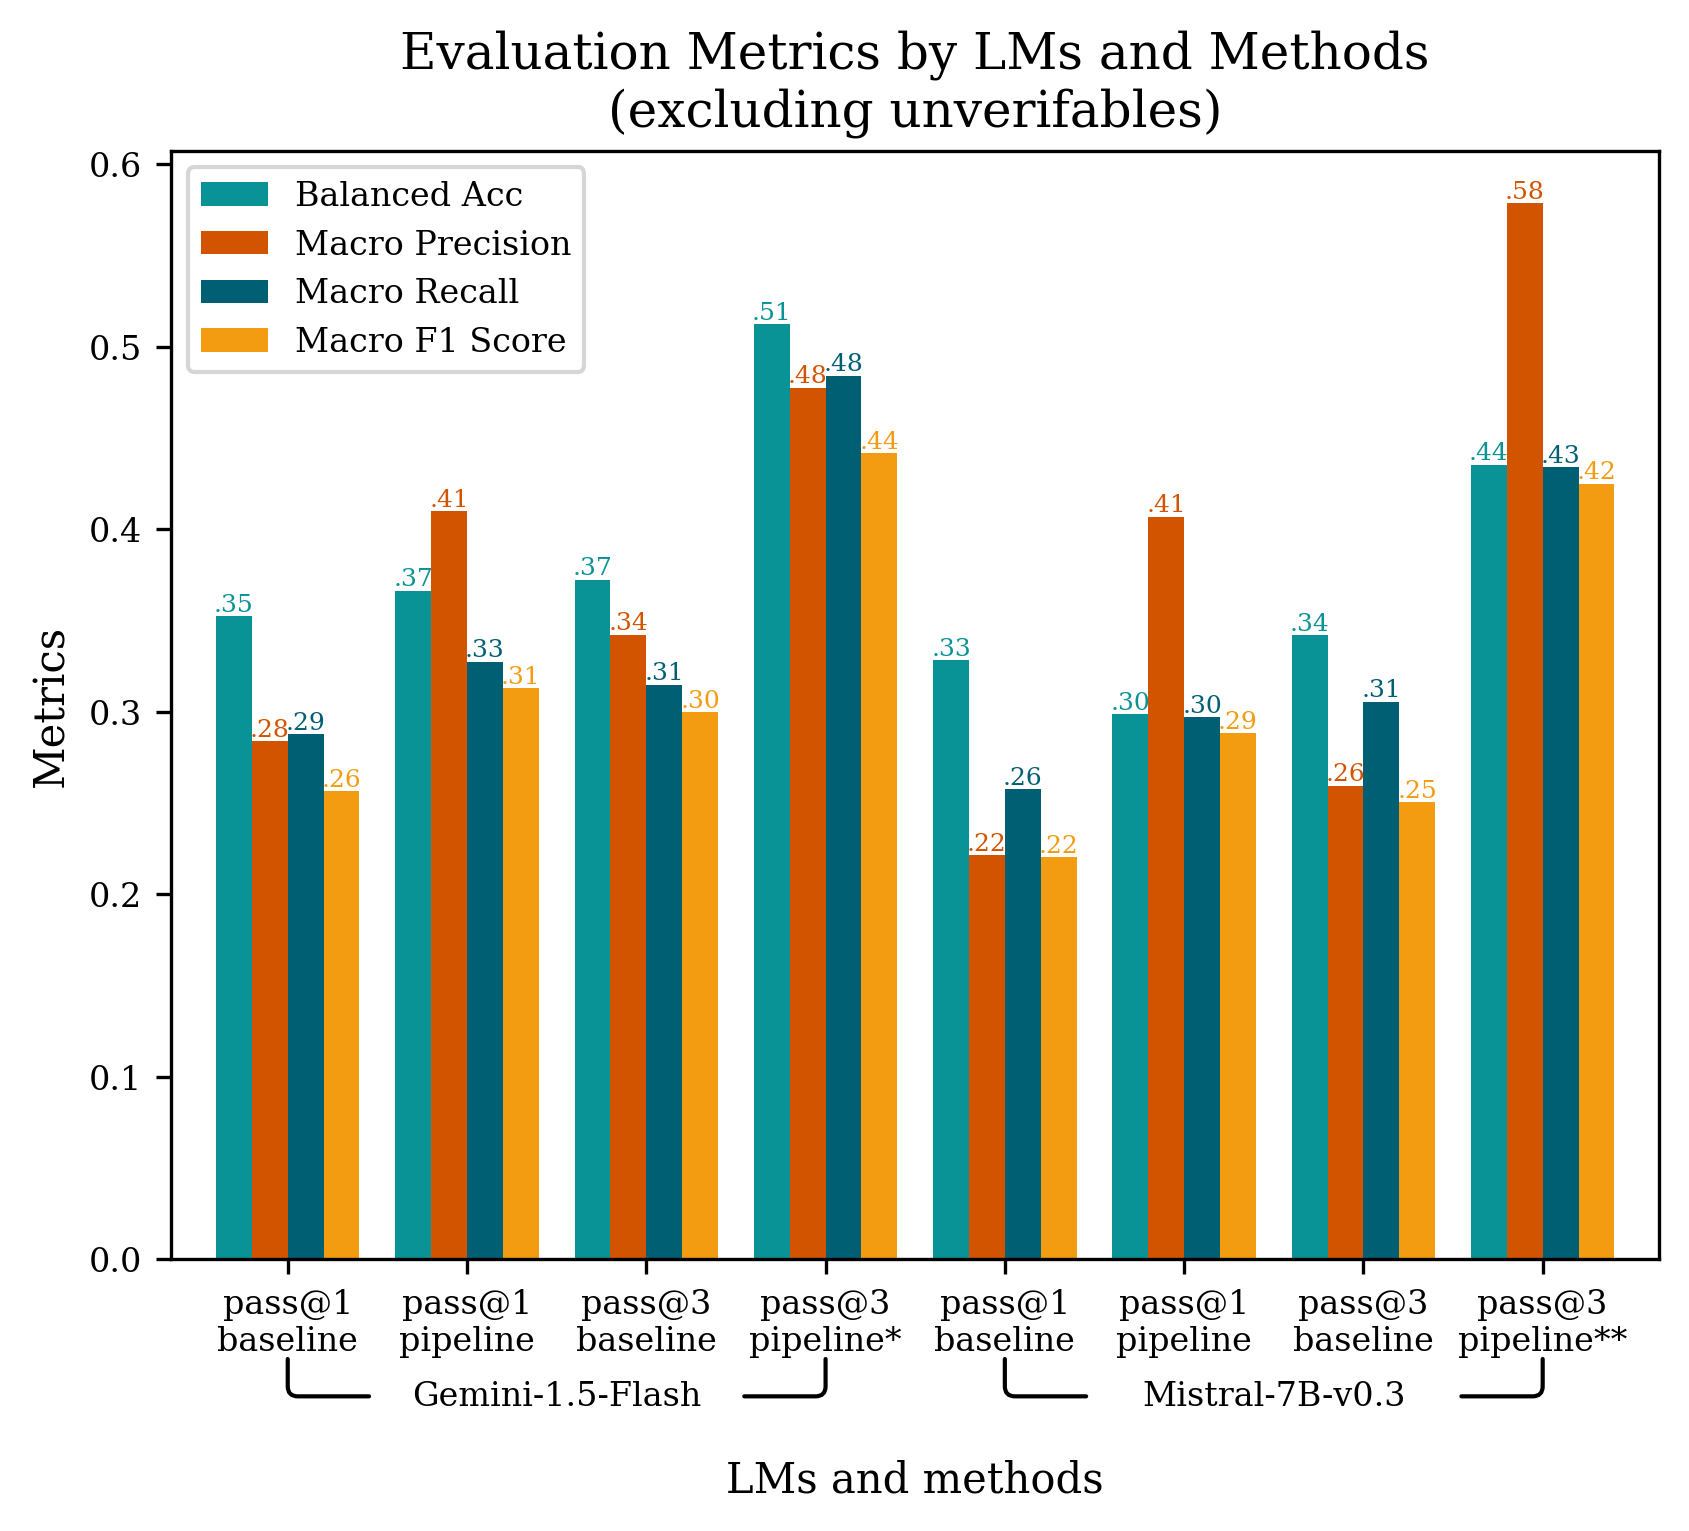

<Figure size 640x480 with 0 Axes>

In [24]:
### plot metrics (excluding unverifiables)
# Set fall color palette
fall_colors = ['#0a9396',
               '#D35400',  # Pumpkin orange
               '#005f73',   # Deep purple
               '#F39C12',]   # Golden yellow   

plt.rcParams["font.family"] = "serif"
# create data 
df = pd.DataFrame([['pass@1 baseline', acc_base1_gemini, p_base1_gemini, r_base1_gemini, f1_base1_gemini], 
                   ['pass@1 pipeline', acc_pipe1_gemini, p_pipe1_gemini, r_pipe1_gemini, f1_pipe1_gemini], 
                   ['pass@3 baseline', acc_base3_gemini, p_base3_gemini, r_base3_gemini, f1_base3_gemini], 
                   ['pass@3 pipeline', acc_pipe3_gemini, p_pipe3_gemini, r_pipe3_gemini, f1_pipe3_gemini],
                   ['pass@1 baseline_mistral', acc_base1_mistral, p_base1_mistral, r_base1_mistral, f1_base1_mistral], 
                   ['pass@1 pipeline_mistral', acc_pipe1_mistral, p_pipe1_mistral, r_pipe1_mistral, f1_pipe1_mistral], 
                   ['pass@3 baseline_mistral', acc_base3_mistral, p_base3_mistral, r_base3_mistral, f1_base3_mistral], 
                   ['pass@3 pipeline_mistral', acc_pipe3_mistral, p_pipe3_mistral, r_pipe3_mistral, f1_pipe3_mistral]], 
                  columns=['Team', 'Balanced Acc', 'Macro Precision', 'Macro Recall', 'Macro F1 Score']) 

fig, ax = plt.subplots(dpi=300)
# plot grouped bar chart with fall colors
df.plot(kind='bar', 
        stacked=False, 
        title='',
        ax=ax,
        width=0.8,
        color=fall_colors)

for bar in ax.patches:
  # The text annotation for each bar should be its height.
  bar_value = bar.get_height()
  text = f'{bar_value:.2f}'
  text = text[-3:]
  # This will give the middle of each bar on the x-axis.
  text_x = bar.get_x() + bar.get_width() / 2
  # get_y() is where the bar starts so we add the height to it.
  text_y = bar.get_y() + bar_value
  # If we want the text to be the same color as the bar, we can
  # get the color like so:
  bar_color = bar.get_facecolor()
  # If you want a consistent color, you can just set it as a constant, e.g. #222222
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=6)
ax.set_xticks(df.index, ["pass@1\nbaseline", "pass@1\npipeline", "pass@3\nbaseline", "pass@3\npipeline*",
                         "pass@1\nbaseline", "pass@1\npipeline", "pass@3\nbaseline", "pass@3\npipeline**"], 
              fontsize=8,
              rotation=0)
ax.set_title('Evaluation Metrics by LMs and Methods\n(excluding unverifables)', fontsize=12)
ax.set_ylabel('Metrics')
ax.set_xlabel('LMs and methods')
ax.xaxis.set_label_coords(0.5, -0.18)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.text(1.5, -0.08, 'Gemini-1.5-Flash', fontsize=8, ha='center')
ax.annotate('', xy=(0.5, -0.075), xytext=(0, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.annotate('', xy=(2.5, -0.075), xytext=(3, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))

ax.text(5.5, -0.08, 'Mistral-7B-v0.3', fontsize=8, ha='center')
ax.annotate('', xy=(4.5, -0.075), xytext=(4, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.annotate('', xy=(6.5, -0.075), xytext=(7, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.legend(loc="upper left",
         facecolor='white',
         fontsize=8)

plt.show()
plt.savefig('eval.png')

In [25]:
### generate metrics (including unverifiables)
cm_base1_gemini, acc_base1_gemini, p_base1_gemini, r_base1_gemini, f1_base1_gemini = generate_metrics(gemini_true, gemini_preds[0])
cm_pipe1_gemini, acc_pipe1_gemini, p_pipe1_gemini, r_pipe1_gemini, f1_pipe1_gemini = generate_metrics(gemini_true, gemini_preds[1])
cm_base3_gemini, acc_base3_gemini, p_base3_gemini, r_base3_gemini, f1_base3_gemini = generate_metrics(gemini_true, gemini_preds[2])
cm_pipe3_gemini, acc_pipe3_gemini, p_pipe3_gemini, r_pipe3_gemini, f1_pipe3_gemini = generate_metrics(gemini_true, gemini_preds[3])

cm_base1_mistral, acc_base1_mistral, p_base1_mistral, r_base1_mistral, f1_base1_mistral = generate_metrics(mistral_true, mistral_preds[0])
cm_pipe1_mistral, acc_pipe1_mistral, p_pipe1_mistral, r_pipe1_mistral, f1_pipe1_mistral = generate_metrics(mistral_true, mistral_preds[1])
cm_base3_mistral, acc_base3_mistral, p_base3_mistral, r_base3_mistral, f1_base3_mistral = generate_metrics(mistral_true, mistral_preds[2])
cm_pipe3_mistral, acc_pipe3_mistral, p_pipe3_mistral, r_pipe3_mistral, f1_pipe3_mistral = generate_metrics(mistral_true, mistral_preds[3])

/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _war

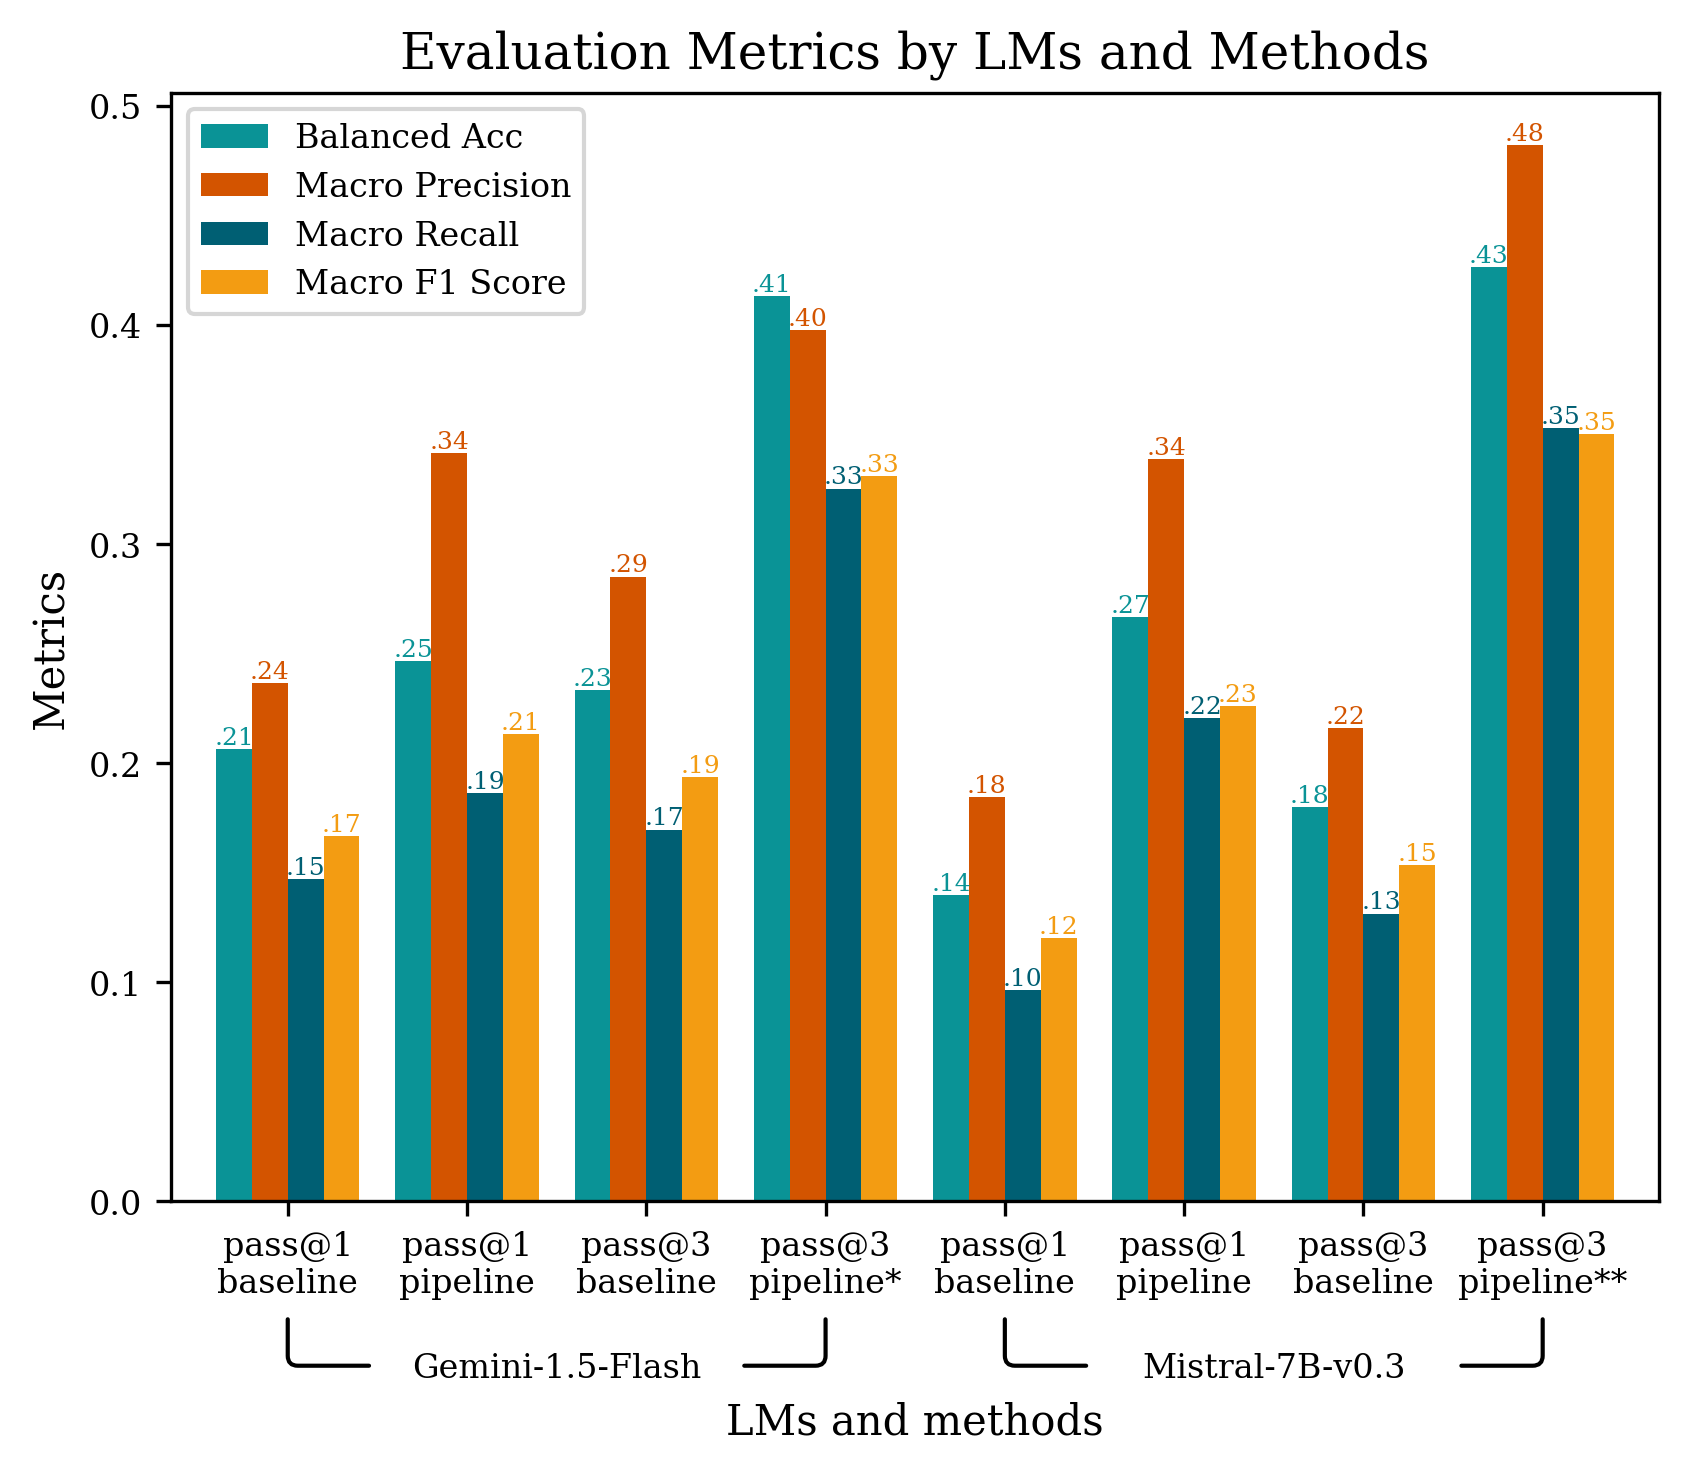

<Figure size 640x480 with 0 Axes>

In [26]:
### plot metrics (including unverifiables)
# Set fall color palette
fall_colors = ['#0a9396',
               '#D35400',  # Pumpkin orange
               '#005f73',   # Deep purple
               '#F39C12',]   # Golden yellow   

plt.rcParams["font.family"] = "serif"
# create data 
df = pd.DataFrame([['pass@1 baseline', acc_base1_gemini, p_base1_gemini, r_base1_gemini, f1_base1_gemini], 
                   ['pass@1 pipeline', acc_pipe1_gemini, p_pipe1_gemini, r_pipe1_gemini, f1_pipe1_gemini], 
                   ['pass@3 baseline', acc_base3_gemini, p_base3_gemini, r_base3_gemini, f1_base3_gemini], 
                   ['pass@3 pipeline', acc_pipe3_gemini, p_pipe3_gemini, r_pipe3_gemini, f1_pipe3_gemini],
                   ['pass@1 baseline_mistral', acc_base1_mistral, p_base1_mistral, r_base1_mistral, f1_base1_mistral], 
                   ['pass@1 pipeline_mistral', acc_pipe1_mistral, p_pipe1_mistral, r_pipe1_mistral, f1_pipe1_mistral], 
                   ['pass@3 baseline_mistral', acc_base3_mistral, p_base3_mistral, r_base3_mistral, f1_base3_mistral], 
                   ['pass@3 pipeline_mistral', acc_pipe3_mistral, p_pipe3_mistral, r_pipe3_mistral, f1_pipe3_mistral]], 
                  columns=['Team', 'Balanced Acc', 'Macro Precision', 'Macro Recall', 'Macro F1 Score']) 

fig, ax = plt.subplots(dpi=300)
# plot grouped bar chart with fall colors
df.plot(kind='bar', 
        stacked=False, 
        title='',
        ax=ax,
        width=0.8,
        color=fall_colors)

for bar in ax.patches:
  # The text annotation for each bar should be its height.
  bar_value = bar.get_height()
  text = f'{bar_value:.2f}'
  text = text[-3:]
  # This will give the middle of each bar on the x-axis.
  text_x = bar.get_x() + bar.get_width() / 2
  # get_y() is where the bar starts so we add the height to it.
  text_y = bar.get_y() + bar_value
  # If we want the text to be the same color as the bar, we can
  # get the color like so:
  bar_color = bar.get_facecolor()
  # If you want a consistent color, you can just set it as a constant, e.g. #222222
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=6)
ax.set_xticks(df.index, ["pass@1\nbaseline", "pass@1\npipeline", "pass@3\nbaseline", "pass@3\npipeline*",
                         "pass@1\nbaseline", "pass@1\npipeline", "pass@3\nbaseline", "pass@3\npipeline**"], 
              fontsize=8,
              rotation=0)
ax.set_title('Evaluation Metrics by LMs and Methods', fontsize=12)
ax.set_ylabel('Metrics')
ax.set_xlabel('LMs and methods')
ax.xaxis.set_label_coords(0.5, -0.18)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.text(1.5, -0.08, 'Gemini-1.5-Flash', fontsize=8, ha='center')
ax.annotate('', xy=(0.5, -0.075), xytext=(0, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.annotate('', xy=(2.5, -0.075), xytext=(3, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))

ax.text(5.5, -0.08, 'Mistral-7B-v0.3', fontsize=8, ha='center')
ax.annotate('', xy=(4.5, -0.075), xytext=(4, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.annotate('', xy=(6.5, -0.075), xytext=(7, -0.05), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
ax.legend(loc="upper left",
         facecolor='white',
         fontsize=8)

plt.show()
plt.savefig('eval.png')

In [27]:
### create classification report for each method & lm (if needed for appendix)
from sklearn.metrics import classification_report

# example code for comparing with gemini pass@1 baseline
print(classification_report(gemini_true, gemini_preds[0]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.74      0.48      0.58        42
           2       0.17      0.22      0.19        27
           3       0.00      0.00      0.00        27
           4       0.17      0.15      0.16        27
           5       0.33      0.04      0.07        27

    accuracy                           0.21       150
   macro avg       0.24      0.15      0.17       150
weighted avg       0.33      0.21      0.24       150



/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/factchecker/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior

## Mean Squared Error

In [28]:
# Extract the first (pass@1) and best of 3 (pass@3) verdicts
# Define the ordinal mapping
VERDICT_MAP = {
    "TRUE": 5,
    "MOSTLY TRUE": 4,
    "HALF TRUE": 3,
    "MOSTLY FALSE": 2,
    "FALSE": 1,
    "UNVERIFIABLE": 0,
    # Weird cases
    "PANTS ON FIRE": 1, # Pants on fire is the same as false
    "MOSTLY UNVERIFIABLE": 0,
    "INDIFFERENT": 0,
    'MOSTLY HALF TRUE': 4,
    'PARTIALLY TRUE': 3,
}

def map_df(model):
    '''map the dataframe to extract the verdicts and calculate the errors'''
    df = pd.read_pickle(f'results_v2_{model}.pkl')

    # Extract the verdicts from the results columns
    df['pred_verdicts_baseline'] = df[f'{model}_baseline_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)
    df['pred_verdicts_pipeline'] = df[f'{model}_pipeline_results'].apply(lambda x: [result['verdict'] for result in x] if x else None)

    # Clean up verdicts with extraneous text (not the cleanest/fastest method but it works)
    # "UNVERIFIABLE (as of the time of writing, the statement cannot be definitively verified or refuted)": 0,
    # 'MOSTLY TRUE - Kelly Ayotte accurately mentioned a relevant bill regarding sanctuary states, but it is unclear if Joyce Craig opposed the bill since she was no longer in office when it was introduced.': 4,
    for i, row in df.iterrows():
        cols = ['pred_verdicts_baseline', 'pred_verdicts_pipeline']
        for col in cols: 
            verdicts = row[col]
            if verdicts:
                verdicts = [v.split(':')[0].split('-')[0].split('(')[0].split('.')[0].strip() if len(v) > 12 else v for v in verdicts]
            df.at[i, col] = verdicts

    df.dropna(subset=['pred_verdicts_pipeline', 'pred_verdicts_baseline'], inplace=True)

    df[['verdict', 'pred_verdicts_baseline', 'pred_verdicts_pipeline']]

    for i in range(len(df)):
        true_val = VERDICT_MAP[df.iloc[i]['verdict']]
        
        # Get pass@1 predictions
        baseline_pred = df['pred_verdicts_baseline'][i][0]
        pipeline_pred = df['pred_verdicts_pipeline'][i][0]
        # Set pass@1 predictions to its own column
        df.at[i, 'baseline_pass1_verdict'] = baseline_pred
        df.at[i, 'pipeline_pass1_verdict'] = pipeline_pred

        # Calculate pass@1 errors
        df.at[i, 'baseline_pass1_MSE'] = (true_val - VERDICT_MAP[baseline_pred])**2 if baseline_pred != "UNVERIFIABLE" else None
        df.at[i, 'pipeline_pass1_MSE'] = (true_val - VERDICT_MAP[pipeline_pred])**2 if pipeline_pred != "UNVERIFIABLE" else None
        
        # Get pass@3 predictions
        sorted_baseline_results = sorted(df.at[i, 'pred_verdicts_baseline'], key=lambda x: (VERDICT_MAP[x] - VERDICT_MAP[df.at[i, 'verdict']])**2 if x != 'UNVERIFIABLE' else 100)
        sorted_pipeline_results = sorted(df.at[i, 'pred_verdicts_pipeline'], key=lambda x: (VERDICT_MAP[x] - VERDICT_MAP[df.at[i, 'verdict']])**2 if x != 'UNVERIFIABLE' else 100)
        best_baseline_pred = sorted_baseline_results[0]
        best_pipeline_pred = sorted_pipeline_results[0]

        # Set pass@3 predictions
        df.at[i, 'baseline_pass3_verdict'] = best_baseline_pred
        df.at[i, 'pipeline_pass3_verdict'] = best_pipeline_pred
        
        # Set pass@3 errors
        df.at[i, 'baseline_pass3_MSE'] = (true_val - VERDICT_MAP[best_baseline_pred])**2 if best_baseline_pred != "UNVERIFIABLE" else None
        df.at[i, 'pipeline_pass3_MSE'] = (true_val - VERDICT_MAP[best_pipeline_pred])**2 if best_pipeline_pred != "UNVERIFIABLE" else None

    # Now you can sort by errors, for example:
    print("\nTop 5 statements with highest pipeline pass@1 errors:")
    display(df.nlargest(5, 'pipeline_pass1_MSE')[['statement', 'verdict', 'pred_verdicts_pipeline', 'pipeline_pass1_MSE']])

    print("\nTop 5 statements with highest pipeline pass@3 errors:")
    display(df.nlargest(5, 'pipeline_pass3_MSE')[['statement', 'verdict', 'pred_verdicts_pipeline', 'pipeline_pass3_MSE']])

    return df

In [29]:
gemini_df = map_df('gemini')


Top 5 statements with highest pipeline pass@1 errors:


,statement,verdict,pred_verdicts_pipeline,pipeline_pass1_MSE
147,“Nearly 90% of all UW graduates stay in Wiscon...,TRUE,"[FALSE, UNVERIFIABLE, FALSE]",16.0
38,"Tim Walz said he carried weapons in war, but “...",TRUE,"[MOSTLY FALSE, MOSTLY TRUE, MOSTLY FALSE]",9.0
119,"“Remember in 2020, 55 of the biggest companies...",FALSE,"[MOSTLY TRUE, MOSTLY FALSE, MOSTLY TRUE]",9.0
13,Says opponent Eric Hovde “supports a $4 trilli...,MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY TRUE, MOSTLY TRUE]",4.0
18,“There was a bill to basically create a ban to...,MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY TRUE, UNVERIFIABLE]",4.0



Top 5 statements with highest pipeline pass@3 errors:


,statement,verdict,pred_verdicts_pipeline,pipeline_pass3_MSE
147,“Nearly 90% of all UW graduates stay in Wiscon...,TRUE,"[FALSE, UNVERIFIABLE, FALSE]",16.0
32,“Dave McCormick is fully against abortion.”,MOSTLY FALSE,"[MOSTLY TRUE, MOSTLY TRUE, UNVERIFIABLE]",4.0
35,"“400,000 workers are now in a union that were ...",MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY FALSE, UNVERIFIABLE]",4.0
41,"“Even before the pandemic, America went into a...",MOSTLY TRUE,"[UNVERIFIABLE, UNVERIFIABLE, MOSTLY FALSE]",4.0
115,"""[The Trump Administration] added more to the ...",HALF TRUE,"[UNVERIFIABLE, FALSE, UNVERIFIABLE]",4.0


In [30]:
mistral_df = map_df('mistral')


Top 5 statements with highest pipeline pass@1 errors:


,statement,verdict,pred_verdicts_pipeline,pipeline_pass1_MSE
108,"""Pharmaceutical medicine has its place, but no...",FALSE,"[MOSTLY TRUE, MOSTLY TRUE, MOSTLY FALSE]",9.0
123,"""We’ve had 12 elections in 24 years in Wiscons...",TRUE,"[MOSTLY FALSE, MOSTLY FALSE, MOSTLY FALSE]",9.0
132,"""In February 2024, Nikki Haley lost the Nevada...",TRUE,"[MOSTLY FALSE, MOSTLY FALSE, FALSE]",9.0
138,"""Former U.S. President Donald Trump's margin o...",FALSE,"[MOSTLY TRUE, MOSTLY TRUE, UNVERIFIABLE]",9.0
4,“The Universities of Wisconsin are 43rd out of...,TRUE,"[HALF TRUE, MOSTLY TRUE, MOSTLY TRUE]",4.0



Top 5 statements with highest pipeline pass@3 errors:


,statement,verdict,pred_verdicts_pipeline,pipeline_pass3_MSE
123,"""We’ve had 12 elections in 24 years in Wiscons...",TRUE,"[MOSTLY FALSE, MOSTLY FALSE, MOSTLY FALSE]",9.0
132,"""In February 2024, Nikki Haley lost the Nevada...",TRUE,"[MOSTLY FALSE, MOSTLY FALSE, FALSE]",9.0
138,"""Former U.S. President Donald Trump's margin o...",FALSE,"[MOSTLY TRUE, MOSTLY TRUE, UNVERIFIABLE]",9.0
29,"“Less than three months ago, Kamala Harris and...",MOSTLY FALSE,"[MOSTLY TRUE, UNVERIFIABLE, MOSTLY TRUE]",4.0
31,"""Typically you have three to four debates in a...",MOSTLY TRUE,"[MOSTLY FALSE, MOSTLY FALSE, MOSTLY FALSE]",4.0


(Baseline: n=89/150, excluded 61 unverifiable) (Pipeline: n=101/150, excluded 49 unverifiable)
(Baseline: n=96/150, excluded 54 unverifiable) (Pipeline: n=121/150, excluded 29 unverifiable)
(Baseline: n=72/150, excluded 78 unverifiable) (Pipeline: n=135/150, excluded 15 unverifiable)
(Baseline: n=89/150, excluded 61 unverifiable) (Pipeline: n=147/150, excluded 3 unverifiable)


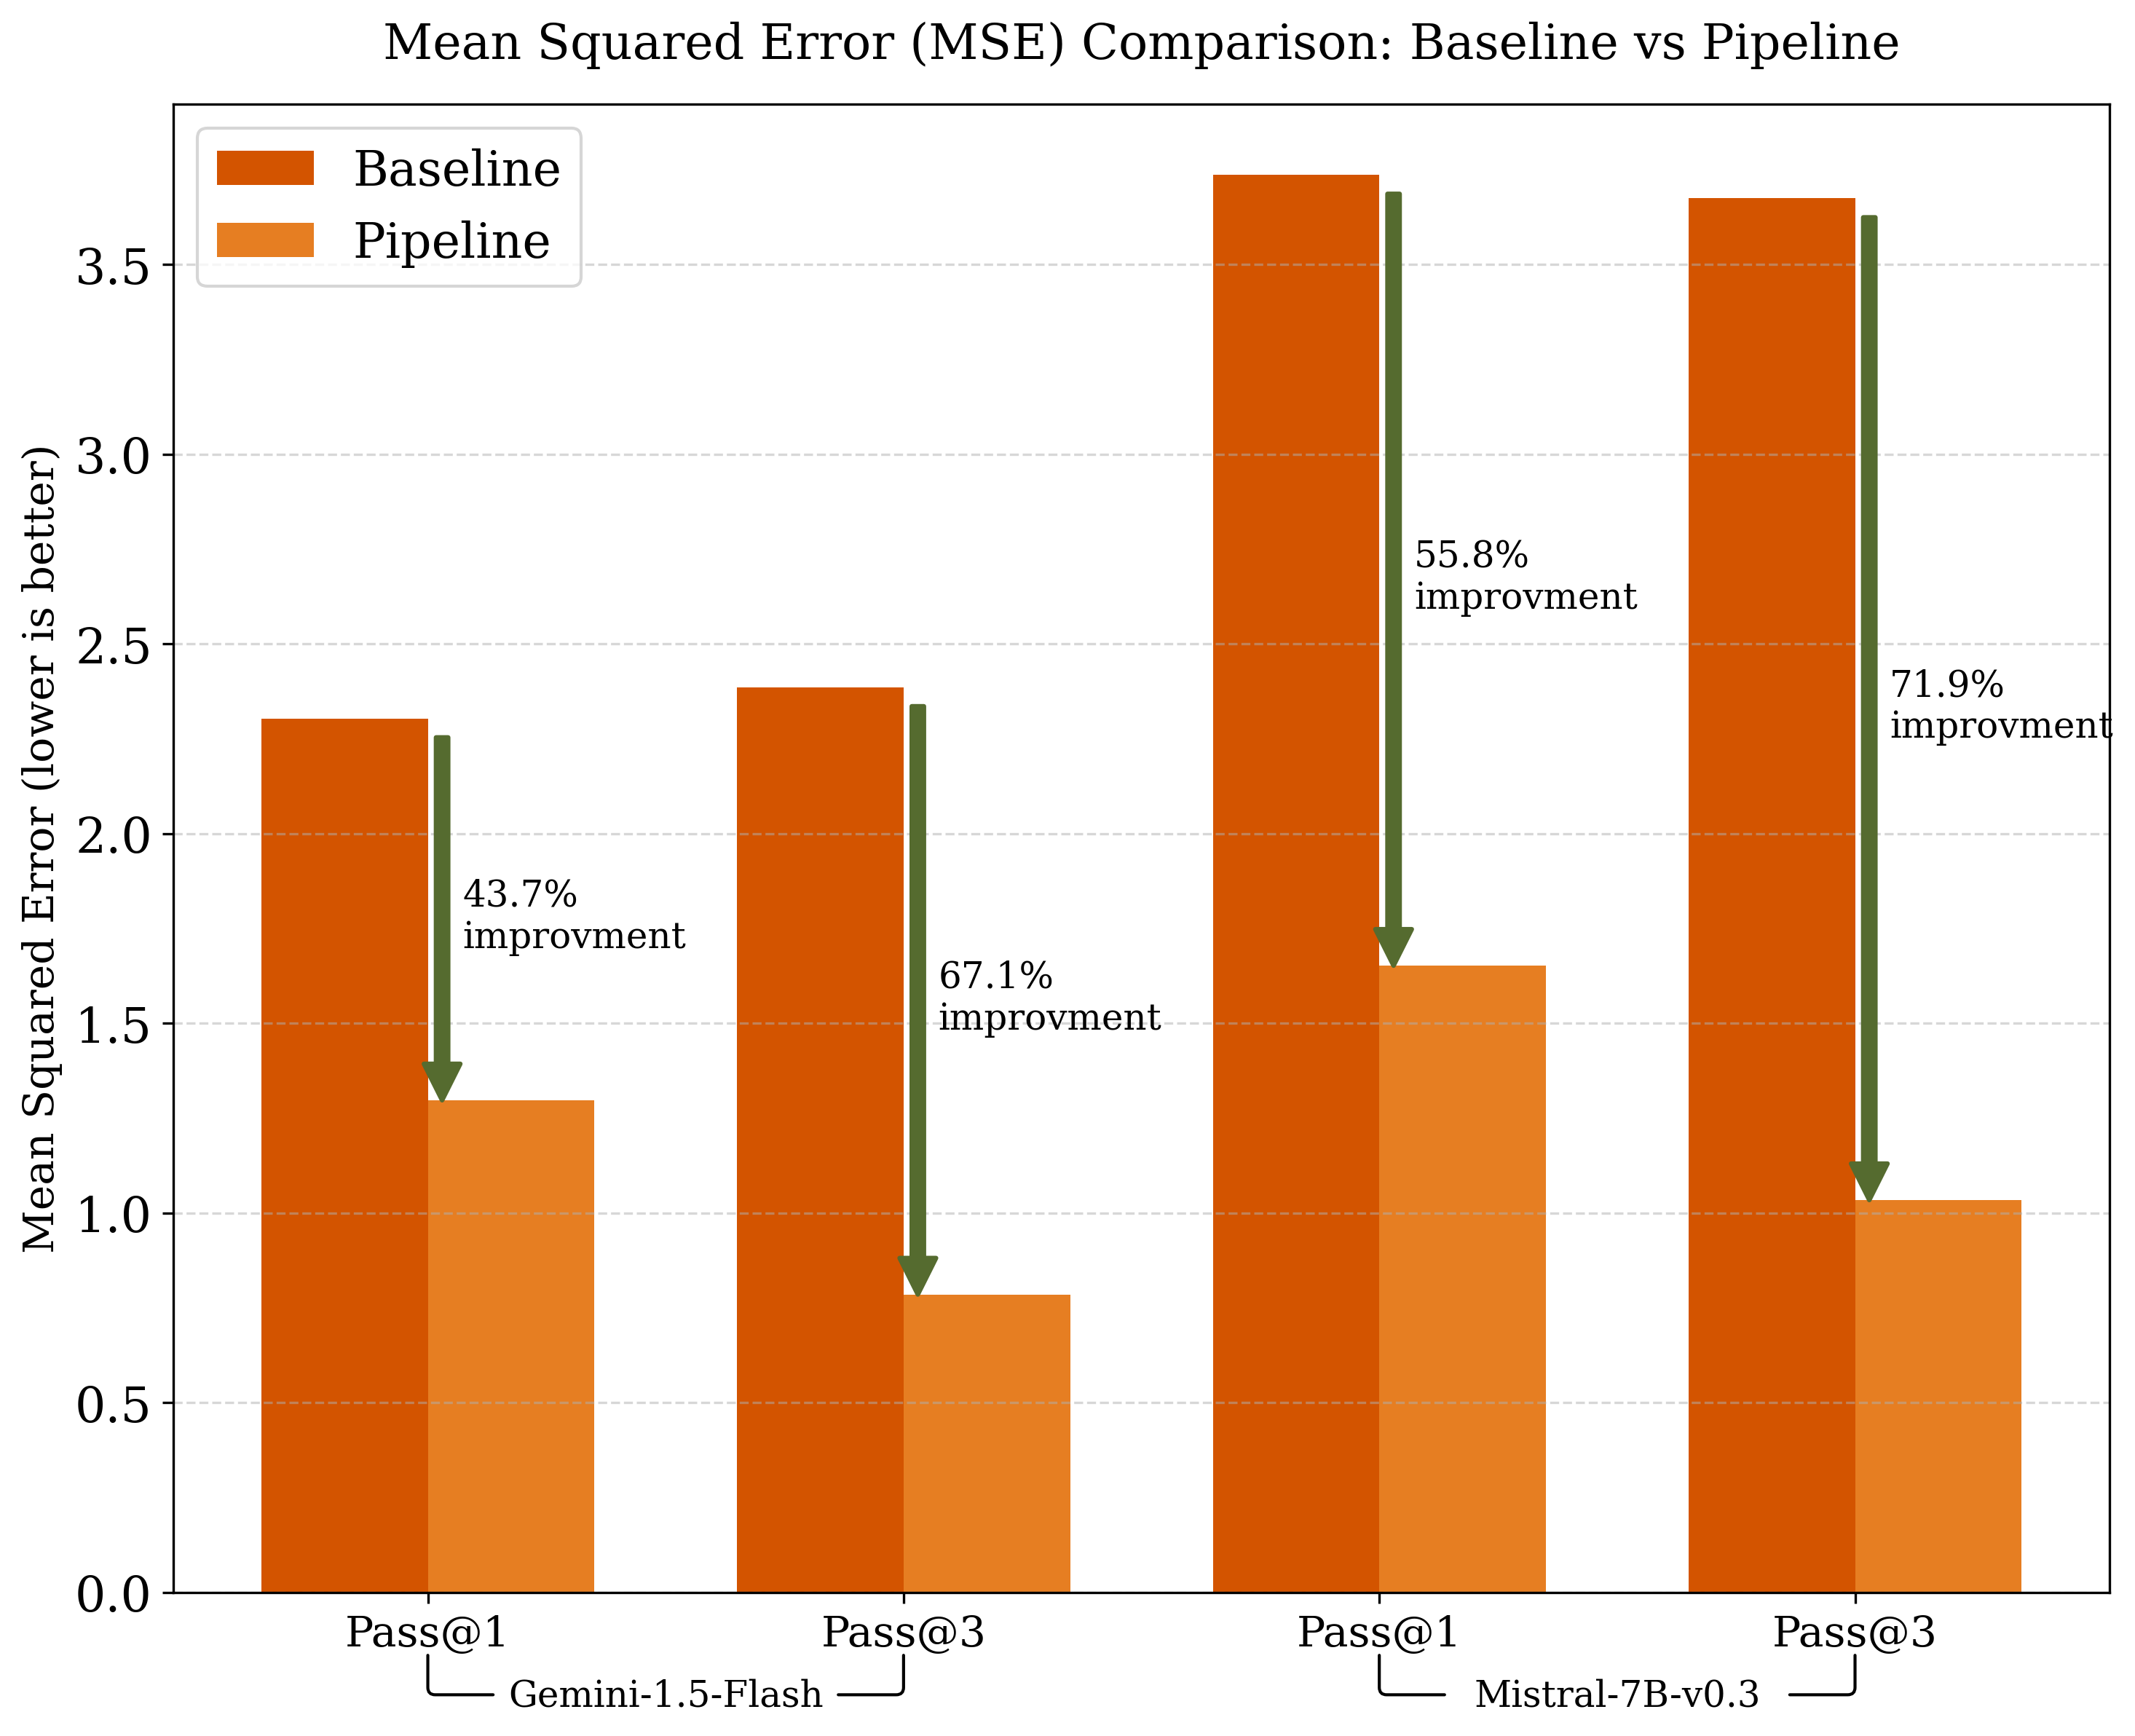

In [31]:
## PLOT: ANALYSIS EXCLUDING UNVERIFIABLE (BASELINE & PIPELINE SEPARATELY)
import numpy as np
import matplotlib.pyplot as plt
from curlyBrace import curlyBrace
import matplotlib.lines as lines

# Calculate ordinal metrics using existing MSE columns
baseline_pass1_values = gemini_df['baseline_pass1_MSE'].dropna().tolist()
pipeline_pass1_values = gemini_df['pipeline_pass1_MSE'].dropna().tolist()
baseline_pass3_values = gemini_df['baseline_pass3_MSE'].dropna().tolist()
pipeline_pass3_values = gemini_df['pipeline_pass3_MSE'].dropna().tolist()

gemini_ordinal_metrics = {
    'baseline_pass@1_mse': np.mean(baseline_pass1_values) if baseline_pass1_values else None,
    'pipeline_pass@1_mse': np.mean(pipeline_pass1_values) if pipeline_pass1_values else None,
    'baseline_pass@3_mse': np.mean(baseline_pass3_values) if baseline_pass3_values else None,
    'pipeline_pass@3_mse': np.mean(pipeline_pass3_values) if pipeline_pass3_values else None
}
print(f"(Baseline: n={len(baseline_pass1_values)}/{len(gemini_df)}, excluded {len(gemini_df)-len(baseline_pass1_values)} unverifiable)",
        f"(Pipeline: n={len(pipeline_pass1_values)}/{len(gemini_df)}, excluded {len(gemini_df)-len(pipeline_pass1_values)} unverifiable)")
print(f"(Baseline: n={len(baseline_pass3_values)}/{len(gemini_df)}, excluded {len(gemini_df)-len(baseline_pass3_values)} unverifiable)",
        f"(Pipeline: n={len(pipeline_pass3_values)}/{len(gemini_df)}, excluded {len(gemini_df)-len(pipeline_pass3_values)} unverifiable)")

# Calculate ordinal metrics using existing MSE columns
baseline_pass1_values = mistral_df['baseline_pass1_MSE'].dropna().tolist()
pipeline_pass1_values = mistral_df['pipeline_pass1_MSE'].dropna().tolist()
baseline_pass3_values = mistral_df['baseline_pass3_MSE'].dropna().tolist()
pipeline_pass3_values = mistral_df['pipeline_pass3_MSE'].dropna().tolist()

mistral_ordinal_metrics = {
    'baseline_pass@1_mse': np.mean(baseline_pass1_values) if baseline_pass1_values else None,
    'pipeline_pass@1_mse': np.mean(pipeline_pass1_values) if pipeline_pass1_values else None,
    'baseline_pass@3_mse': np.mean(baseline_pass3_values) if baseline_pass3_values else None,
    'pipeline_pass@3_mse': np.mean(pipeline_pass3_values) if pipeline_pass3_values else None
}

print(f"(Baseline: n={len(baseline_pass1_values)}/{len(mistral_df)}, excluded {len(mistral_df)-len(baseline_pass1_values)} unverifiable)",
    f"(Pipeline: n={len(pipeline_pass1_values)}/{len(mistral_df)}, excluded {len(mistral_df)-len(pipeline_pass1_values)} unverifiable)")
print(f"(Baseline: n={len(baseline_pass3_values)}/{len(mistral_df)}, excluded {len(mistral_df)-len(baseline_pass3_values)} unverifiable)",
        f"(Pipeline: n={len(pipeline_pass3_values)}/{len(mistral_df)}, excluded {len(mistral_df)-len(pipeline_pass3_values)} unverifiable)")

# Plot results and show % improvement (from baseline to pipeline, for both pass@1 and pass@3)
fig, axes = plt.subplots(1, 1, figsize = (10, 8), dpi = 300)

# Define fall colors
colors = ['#D35400', '#E67E22']  # Deep orange and lighter orange
bar_width = 0.35
index = np.arange(4)  # Two groups for Pass@1 and Pass@3

# Create bars
baseline_bars = axes.bar(index - bar_width/2, 
                       [gemini_ordinal_metrics['baseline_pass@1_mse'], gemini_ordinal_metrics['baseline_pass@3_mse'], 
                        mistral_ordinal_metrics['baseline_pass@1_mse'], mistral_ordinal_metrics['baseline_pass@3_mse'], ], 
                       bar_width, label='Baseline', color=colors[0])
pipeline_bars = axes.bar(index + bar_width/2, 
                       [gemini_ordinal_metrics['pipeline_pass@1_mse'], gemini_ordinal_metrics['pipeline_pass@3_mse'],
                        mistral_ordinal_metrics['pipeline_pass@1_mse'], mistral_ordinal_metrics['pipeline_pass@3_mse']], 
                       bar_width, label='Pipeline', color=colors[1])

# Customize the plot
axes.set_ylabel('Mean Squared Error (lower is better)', fontsize=14)
axes.yaxis.set_tick_params(labelsize=16)
axes.set_title(f'Mean Squared Error (MSE) Comparison: Baseline vs Pipeline', fontsize=16, pad=15)
axes.set_xticks(index, ["Pass@1", "Pass@3", "Pass@1", "Pass@3"], fontsize=14)
axes.text(0.5, -0.3, 'Gemini-1.5-Flash', fontsize = 12, ha='center')
axes.annotate('', xy=(0.85, -0.27), xytext=(1, -0.15), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
axes.annotate('', xy=(0.15, -0.27), xytext=(0, -0.15), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))

axes.text(2.5, -0.3, 'Mistral-7B-v0.3', fontsize = 12, ha='center')
axes.annotate('', xy=(2.85, -0.27), xytext=(3, -0.15), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))
axes.annotate('', xy=(2.15, -0.27), xytext=(2, -0.15), textcoords='data', annotation_clip=False,
            arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=90,angleB=0,rad=10'))

axes.legend(fontsize = 16)

# Add improvement arrows and percentages
for idx, (baseline_val, pipeline_val) in enumerate([
    (gemini_ordinal_metrics['baseline_pass@1_mse'], gemini_ordinal_metrics['pipeline_pass@1_mse']),
    (gemini_ordinal_metrics['baseline_pass@3_mse'], gemini_ordinal_metrics['pipeline_pass@3_mse']),
    (mistral_ordinal_metrics['baseline_pass@1_mse'], mistral_ordinal_metrics['pipeline_pass@1_mse']),
    (mistral_ordinal_metrics['baseline_pass@3_mse'], mistral_ordinal_metrics['pipeline_pass@3_mse']),
]): 
    # curlyBrace(fig, axes, [idx+0.05, baseline_val - 0.03], [idx+0.05, pipeline_val + 0.03], 0.03, bool_auto=True, color = 'black', lw=1, int_line_num=1)
    improvement = ((baseline_val - pipeline_val) / baseline_val * 100)
    # Draw arrow
    mid_height = (baseline_val + pipeline_val) / 2
    axes.annotate(
        f'{improvement:.1f}%\nimprovment', 
        xy=(idx + 0.1, mid_height),
        xytext=(idx + 0.073, mid_height - 0.1),
        fontsize=12,
    )
    
    # Draw arrow
    axes.annotate(f'',
                xy=(idx + 0.03, pipeline_val),
                xytext=(idx + 0.03, baseline_val - 0.05),
                ha='center',
                va='bottom',
                color='green',
                fontweight='bold',
                arrowprops=dict(
                              color='darkolivegreen',
                              lw = 1.5,
                              connectionstyle='arc3,rad=0'))
# Add grid for better readability
axes.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('mse.png', dpi = 500, bbox_inches="tight")

In [32]:
preds = df_gemini[f'gemini_pipeline_results'].apply(lambda x: [result['reasoning'] for result in x] if x else None)

### Cohen's Quadratic Weighted Kappa

In [33]:
### CALCULATING COHEN'S QUADRATIC WEIGHTED KAPPA
# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [35]:
gemini_base_pass_1 = quadratic_weighted_kappa(gemini_cohen_true[0], gemini_cohen_pred[0])
gemini_pipe_pass_1 = quadratic_weighted_kappa(gemini_cohen_true[1], gemini_cohen_pred[1])
gemini_base_pass_3 = quadratic_weighted_kappa(gemini_cohen_true[2], gemini_cohen_pred[2])
gemini_pipe_pass_3 = quadratic_weighted_kappa(gemini_cohen_true[3], gemini_cohen_pred[3])

In [ ]:
mistral_base_pass_1 = quadratic_weighted_kappa(mistral_cohen_true[0], mistral_cohen_pred[0])
mistral_pipe_pass_1 = quadratic_weighted_kappa(mistral_cohen_true[1], mistral_cohen_pred[1])
mistral_base_pass_3 = quadratic_weighted_kappa(mistral_cohen_true[2], mistral_cohen_pred[2])
mistral_pipe_pass_3 = quadratic_weighted_kappa(mistral_cohen_true[3], mistral_cohen_pred[3])

In [38]:
print(f"Gemini-1.5-Flash Pass@1 Baseline Cohen's k: {gemini_base_pass_1:.4f}")
print(f"Gemini-1.5-Flash Pass@1 Pipeline Cohen's k: {gemini_pipe_pass_1:.4f}")
print(f"Gemini-1.5-Flash Pass@3 Baseline Cohen's k: {gemini_base_pass_3:.4f}")
print(f"Gemini-1.5-Flash Pass@3 Pipeline Cohen's k: {gemini_pipe_pass_3:.4f}")
print(f"Mistral-7B-v0.3 Pass@1 Baseline Cohen's k: {mistral_base_pass_1:.4f}")
print(f"Mistral-7B-v0.3 Pass@1 Pipeline Cohen's k: {mistral_pipe_pass_1:.4f}")
print(f"Mistral-7B-v0.3 Pass@3 Baseline Cohen's k: {mistral_base_pass_3:.4f}")
print(f"Mistral-7B-v0.3 Pass@3 Pipeline Cohen's k: {mistral_pipe_pass_3:.4f}")       

Gemini-1.5-Flash Pass@1 Baseline Cohen's k: 0.4341
Gemini-1.5-Flash Pass@1 Pipeline Cohen's k: 0.6814
Gemini-1.5-Flash Pass@3 Baseline Cohen's k: 0.4436
Gemini-1.5-Flash Pass@3 Pipeline Cohen's k: 0.8096
Mistral-7B-v0.3 Pass@1 Baseline Cohen's k: 0.2321
Mistral-7B-v0.3 Pass@1 Pipeline Cohen's k: 0.5163
Mistral-7B-v0.3 Pass@3 Baseline Cohen's k: 0.2840
Mistral-7B-v0.3 Pass@3 Pipeline Cohen's k: 0.7018
